In [1]:
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model
import pickle

2025-04-26 10:53:28.741160: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load CSV
df = pd.read_csv("../data/metadata.csv")

# Pick one image to test
img_path = df.loc[2485, 'filepath']
true_label = df.loc[2485, 'label']


def generate_gradcam_keras(model, img_array, target_layer_name, class_index=None):
    # Get the model's prediction
    preds = model.predict(img_array)
    pred_index = np.argmax(preds[0]) if class_index is None else class_index

    # Get the output of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, pred_index]

    # Compute gradients of the top predicted class
    grads = tape.gradient(loss, conv_outputs)

    # Pool the gradients over all spatial locations
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map by its gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [14]:
# --- Load and preprocess image ---
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Keep a version for display
img_display = cv2.imread(img_path)
img_display = cv2.resize(img_display, (224, 224))

#load trained densenet model
with open("/rds/general/user/js4124/home/ML_BreakHis/DenseNet/densenet_hpo/models/hpo_model_1_binary.pickle", "rb") as openfile:
    model = pickle.load(openfile)
    


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


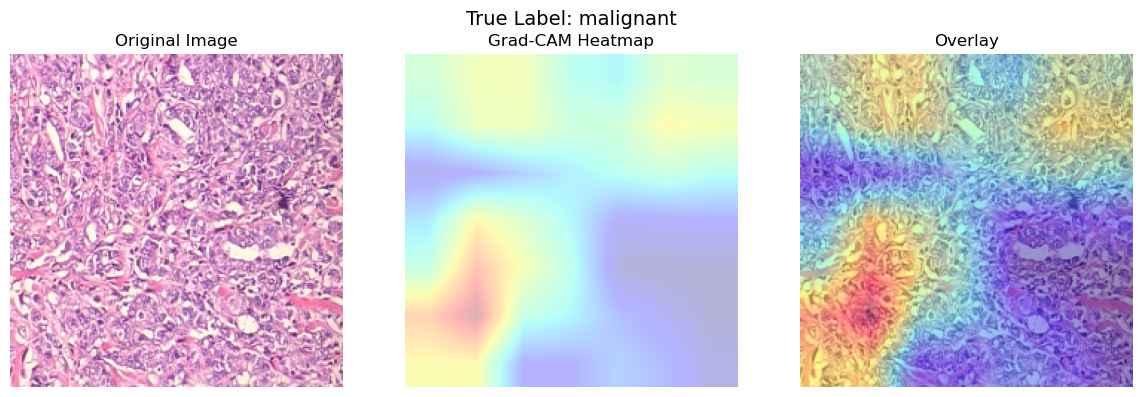

In [16]:
# --- Choose last conv layer for Grad-CAM ---
last_conv_layer = "conv5_block16_concat"  # ResNet50 specific

# --- Generate Grad-CAM ---
heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

# --- Resize heatmap and create overlay ---
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
overlay = heatmap_colored * 0.4 + img_display

# --- Plotting side-by-side ---
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Original
ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis('off')

# Heatmap only
ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.3)
ax[1].set_title("Grad-CAM Heatmap")
ax[1].axis('off')

# Overlay
ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
ax[2].set_title("Overlay")
ax[2].axis('off')

# Optional: Add a super title
fig.suptitle(f"True Label: {true_label}", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
for i, layer in enumerate(model.layers):
    if i >:
        print(i, layer.name)

401 conv5_block13_1_relu
402 conv5_block13_2_conv
403 conv5_block13_concat
404 conv5_block14_0_bn
405 conv5_block14_0_relu
406 conv5_block14_1_conv
407 conv5_block14_1_bn
408 conv5_block14_1_relu
409 conv5_block14_2_conv
410 conv5_block14_concat
411 conv5_block15_0_bn
412 conv5_block15_0_relu
413 conv5_block15_1_conv
414 conv5_block15_1_bn
415 conv5_block15_1_relu
416 conv5_block15_2_conv
417 conv5_block15_concat
418 conv5_block16_0_bn
419 conv5_block16_0_relu
420 conv5_block16_1_conv
421 conv5_block16_1_bn
422 conv5_block16_1_relu
423 conv5_block16_2_conv
424 conv5_block16_concat
425 bn
426 relu
427 global_average_pooling2d
428 dense
429 dropout
430 dense_1


In [18]:
# save last layer of each dense block in a list
l_dense_final_layer =["conv2_block6_concat", "conv3_block12_concat", "conv4_block24_concat", "conv5_block16_concat"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


/rds/general/user/js4124/home/anaconda3/envs/ml_py/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


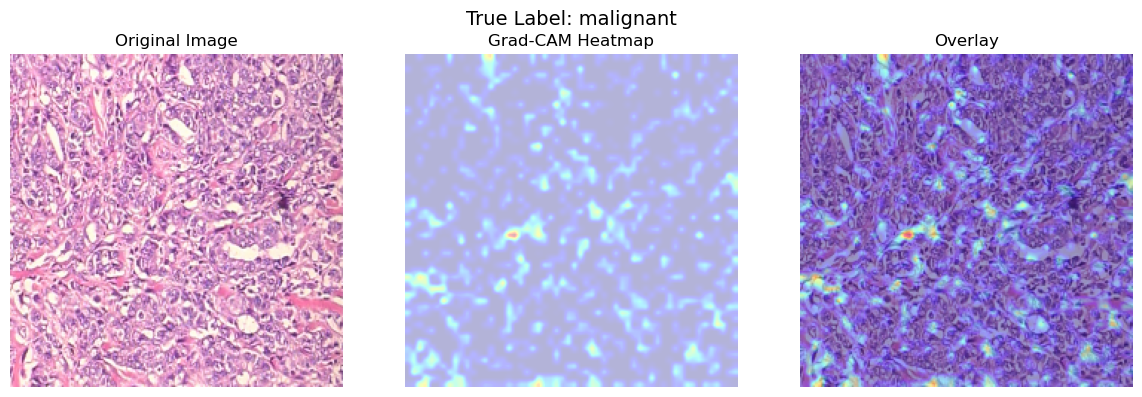

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


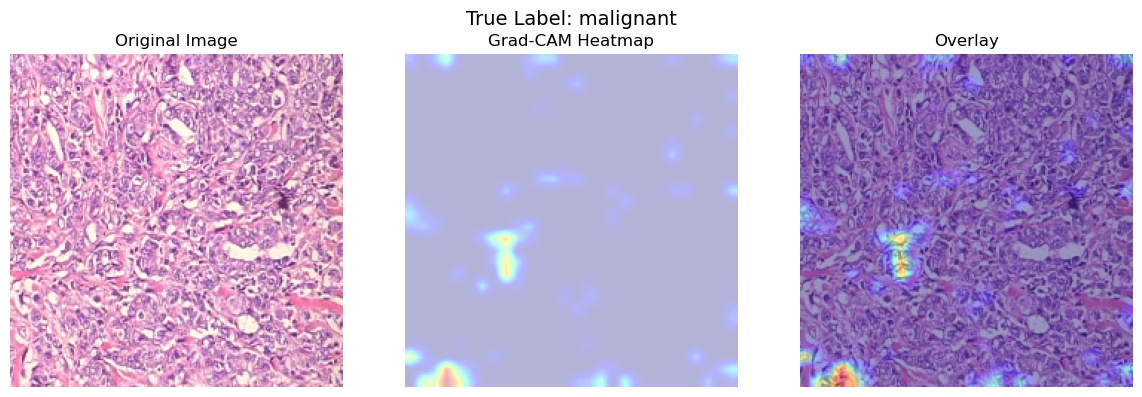

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step


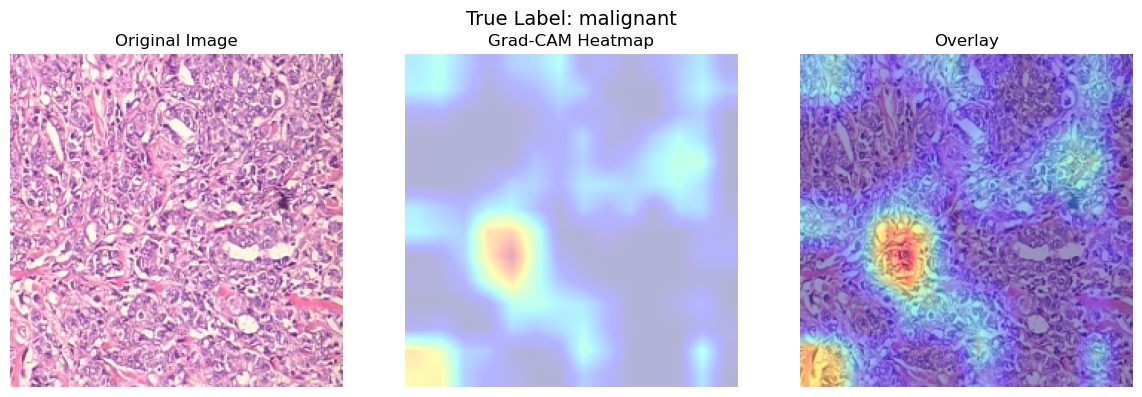

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


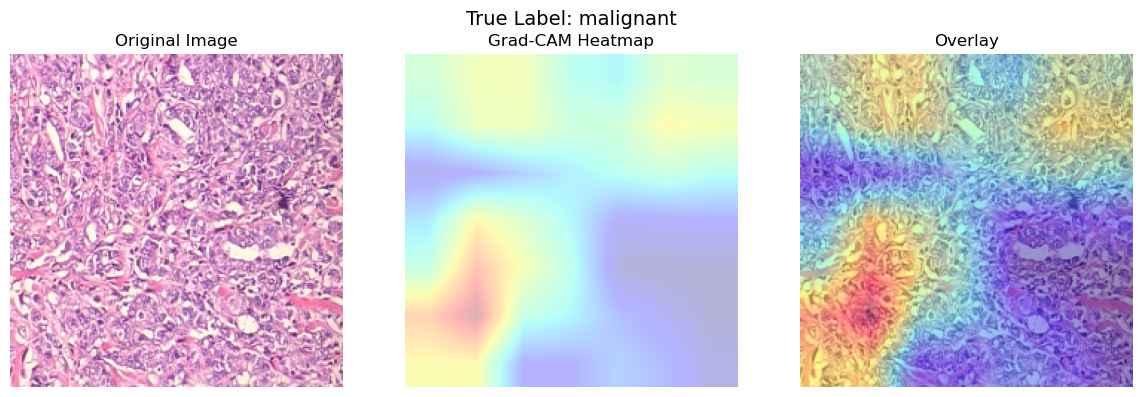

In [19]:
for i in range(len(l_dense_final_layer)):
# --- Choose last conv layer for Grad-CAM ---
    last_conv_layer = l_dense_final_layer[i]

    # --- Generate Grad-CAM ---
    heatmap = generate_gradcam_keras(model, img_array, last_conv_layer)

    # --- Resize heatmap and create overlay ---
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = heatmap_colored * 0.4 + img_display

    # --- Plotting side-by-side ---
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Original
    ax[0].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    # Heatmap only
    ax[1].imshow(heatmap_resized, cmap='jet', alpha =0.3)
    ax[1].set_title("Grad-CAM Heatmap")
    ax[1].axis('off')

    # Overlay
    ax[2].imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    ax[2].imshow(heatmap_resized, cmap='jet', alpha =0.4)
    ax[2].set_title("Overlay")
    ax[2].axis('off')

    # Optional: Add a super title
    fig.suptitle(f"True Label: {true_label}", fontsize=14)
    plt.tight_layout()
    plt.show()